In [1]:
import h5py
import re
import hickle as hkl
import torch
import torch.nn as nn
#from torch.legacy.nn import Reshape
import graphviz
import torch.nn.functional as F
from torch.autograd import Variable
#from visualize import make_dot
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread, imshow
import time
import logging
from math import log,sqrt

/home/shahzad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
torch.cuda.current_device()

In [2]:
# import torch
# import torch.nn.functional as F
from torch import nn

from misc import initialize_weights1


class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights1(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        x=F.upsample(final, x.size()[2:], mode='bilinear')
        m = torch.nn.Softmax()
        x = m(x)
        #x = x.view(-1,360,480)
        
        return x


In [3]:
net = UNet(12)
#print(net)

/home/shahzad/Desktop/Semantic_segmentation/misc.py:20: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


In [ ]:
input=Variable(torch.randn(2,3,360,480))
output=net(input)


In [4]:
def get_predictions(output_batch):
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

In [ ]:
# print(output.shape)
# a=get_predictions(output)
# print(a.shape)
# # b= a.view(-1,360,480)
# # print(b.shape)
# # print(b)

In [ ]:
# print(criterion(output,tar))

In [5]:
file = h5py.File('Semantic1_TrainDataset.h5')
xtrainT = torch.from_numpy(np.array(file['xtrain'],dtype=np.float32)).float()
ytrainT = torch.from_numpy(np.array(file['ytrain'],dtype=np.float32)).float()
#xtrain = np.array(file['xtrain'],dtype=np.float32)
#ytrain = np.array(file['ytrain'],dtype=np.float32)

KeyboardInterrupt: 

In [6]:
file = h5py.File('Semantic1_TestDataset.h5')
xtestT = torch.from_numpy(np.array(file['xtest'],dtype=np.float32)).float()
ytestT = torch.from_numpy(np.array(file['ytest'],dtype=np.float32)).float()
#xtest = np.array(file['xtest'],dtype=np.float32)
#ytest = np.array(file['ytest'],dtype=np.float32)

In [7]:
def batch_rgb_to_bgr(batch):
    #print(batch.size())
    (r, g, b) = torch.chunk(batch, 3, 1)
    #print(r.size())
    batch1 = torch.cat((b, g, r),1)
    #print(batch1.size())
    return batch1

In [ ]:
xtrainT = batch_rgb_to_bgr(xtrainT)
print(xtrainT.size(),ytrainT.size())

In [ ]:
xtrainT = torch.div(xtrainT,255.0)
#ytrainT = torch.div(ytrainT,255.0)

In [8]:
xtestT = batch_rgb_to_bgr(xtestT)

print(xtestT.size(),ytestT.size())

torch.Size([43, 3, 360, 480]) torch.Size([43, 1, 360, 480])


In [9]:
xtestT = torch.div(xtestT,255.0)
#ytestT = torch.div(ytestT,255.0)

In [ ]:
#print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))
print(torch.min(xtrainT), torch.max(xtrainT))

In [ ]:
print(xtrainT.size(), ytrainT.size(), xtestT.size(), ytestT.size())

In [10]:
class Normalize(object):
    """
    Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [10]:
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
xtrainT = norm(xtrainT)


NameError: name 'xtrainT' is not defined

In [11]:
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
xtestT = norm(xtestT)

In [ ]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

In [ ]:
#xtestT = batch_rgb_to_bgr(xtestT)
#xtestT = torch.div(xtestT,255.0)
#mn = [0.406,0.456,0.485]
#sd = [0.225,0.224,0.229]
#norm = Normalize(mn,sd)
#xtestT = norm(xtestT)
#print(xtestT.size(), ytestT.size())
#print(torch.min(xtestT), torch.max(xtestT),torch.min(ytestT), torch.max(ytestT))

In [ ]:
##def train(model, loss, optimizer, x_val, y_val, validPixel, batch_sz):
def train(model, loss, optimizer, x_val, y_val,batch_size):
    x = Variable(x_val,requires_grad = False).cuda()
    y = Variable(y_val,requires_grad = False).type('torch.LongTensor').cuda()
    
    optimizer.zero_grad()
    
    fx = model.forward(x)
    
    #print fx.data[0][0][64][87]
    #fx = model5.forward(Variable(xtest2[start:end], volatile=True).cuda())
    ##output = loss.forward(fx,y,validPixel,batch_sz)
    output = loss(fx,y)
    #output = loss(fx, y)
    output.backward()
    
    optimizer.step()
    
    return output.item()

In [ ]:
#custom loss function.... this will be reverse Huber...

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self,inp, tar):
        #target is the ground truth value...
        #k = torch.mean(inp[:,0])
        '''
        if (k >= 1.48 and k <= 1.65):
            diff = torch.abs(tar[:,1]-inp[:,1])
            loss = torch.mean(torch.pow(diff,2))
        else:
        '''
#         diff1 = (tar[:,0]-inp[:,0]) #*(180/np.pi)
#         diff=torch.pow(diff,2)
#         loss = torch.mean(diff)
        loss = torch.sqrt( torch.mean( torch.abs(torch.log(tar)-torch.log(inp)) ** 2 ) )
        #print(loss)
        return loss
        '''
        c1 = c.data[0] 
        temp = diff > c1
        check1 = torch.prod(temp)
        
        if check1 == 0:
            lossval = torch.mean(diff)
        else:
            temp4 = torch.pow(diff,2)
            d = torch.pow(c,2)
            temp4 = temp4.add(d.expand_as(temp4))
            lossval = torch.mean(temp4/(2*c))
        return lossval
        '''

In [ ]:
#custom loss function....

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        
    def forward(self,input, target):
        diff = torch.abs(target-input)
        temp1 = diff**2
        temp2 = torch.mean(temp1)
        return torch.sqrt(temp2)

In [ ]:
class LogLoss(nn.Module):
    def __init__(self):
        super(LogLoss, self).__init__()
        
    def forward(self,inp, tar):
     
        loss = torch.sqrt( torch.mean( torch.abs(torch.log(tar)-torch.log(inp)) ** 2 ) )
        #print(loss)
        return loss
        

In [ ]:
import math
class BerhuLoss(nn.Module):
    def __init__(self):
        super(BerhuLoss, self).__init__()
        
    def forward(self,inp, tar):
        #target is the ground truth value...
        mt = tar[:,0]
        mp = inp[:,0]
        diff = torch.abs(mt-mp)        
        lossval = 0.0        
        c = 0.2 * torch.max(diff)
        l1 = torch.mean(diff)
        l2 = torch.mean(torch.pow(diff,2))
        if l1 <= c:
            lossval = l1
        else:
            lossval = (l2+c**2)/(2*c)
        
        return lossval




In [ ]:
#alpha = torch.FloatTensor(ytrainT[5,0])
alpha = ytrainT[5,0]
#print(alpha.shape)
xt = torch.FloatTensor([np.cos(alpha),np.sin(alpha)])
print(ytrainT[5,0],xt.size())

In [ ]:
alpha = ytrainT[5:10,0]
print(torch.cos(alpha[0:1]-alpha[1:2]))
xt = torch.stack([torch.cos(alpha[0:1]),torch.sin(alpha[0:1])])
xp = torch.stack([torch.cos(alpha[1:2]),torch.sin(alpha[1:2])])
print(xt[0],xt[1])
#print(los)

In [ ]:
class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()
        
    def forward(self,inp, tar,batch_sz):
        alpha_t = tar[:,0]
        alpha_p = inp[:,0]
        #xt = torch.stack([torch.cos(alpha_t),torch.sin(alpha_t)])
        #xp = torch.stack([torch.cos(alpha_p),torch.sin(alpha_p)])
        #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #loss = cos(xt, xp)
        #return loss
        loss = Variable(torch.FloatTensor(batch_sz).zero_(), requires_grad=False).cuda()
        for i in range(batch_sz):          
            loss[i] = torch.cos(alpha_t[i:i+1]-alpha_p[i:i+1])
            
        lossval = 1.0-torch.mean(loss)    
        #print(lossval)
        return lossval
        

In [ ]:
xtrainT=xtrainT[0:20]
ytrainT=ytrainT[0:20]
print(xtrainT.size(),ytrainT.size())

In [ ]:
#MUST UNCOMMENT BELOW LINE...
    
net = net.cuda()

#loading the model after the weights of epoch50.. to check what loss the model gives if lr is taken as 0.0001
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

#criterion = RMSELoss()
#criterion = BerhuLoss()
#criterion = EuclideanLoss()
#criterion = nn.MSELoss()
#criterion = CosineLoss()
#criterion = torch.nn.MSELoss(size_average=False)
#criterion = CustomLoss()
#criterion = LogLoss()
#criterion = RMSELoss()
criterion = nn.CrossEntropyLoss()
#criterion = BerhuLoss()
#criterion =  CosineLoss()
#criterion = nn.MSELoss()
#criterion = nn.LogLoss()
criterion.cuda()

currepochloss =float('Inf')
#epochs, n_examples, i, batch_size, flag = 1,5900, 0, 5, 0
epochs, n_examples, i, batch_size, flag = 40, 20, 0, 2, 0


while i != epochs:
    since = time.time()
    cost, batchloss = 0.0, 0.0
    num_batches = n_examples//batch_size
    #print num_batches    #indices = np.random.permutation(5600)
    #indices = np.random.permutation(3524)
    
    #indices = np.random.permutation(5900)
    indices = np.random.permutation(n_examples)
    samplesUnprocessed = np.size(indices)
    
    #batchwise training starts here...
    for k in range(num_batches):
        since1 = time.time()
       # print("bacth number:"+str(k))
        xtrain3 = torch.FloatTensor(batch_size,3,360,480)
        ytrain3 = torch.FloatTensor(batch_size,360,480)
        ##validPixel = torch.FloatTensor(batch_size,480,640)
        
        for ind in range(batch_size):
            #ind1 = np.random.randint(0,5599)
            ind1 = np.random.randint(0,samplesUnprocessed)
            #ind1 = np.random.randint(0,794)
            #ind1 = np.random.randint(0,794)            
            newxind = indices[ind1]            
            xtrain3[ind] = xtrainT[newxind]
            ytrain3[ind] = ytrainT[newxind]
            ##validPixel[ind] = imgValidTrain2[newxind]
            
            #print ytrain3[ind,0,0,0], ytrain2[newxind,0,0,0]
            indices = np.delete(indices,ind1)
            samplesUnprocessed = samplesUnprocessed - 1
        
        #start, end = k*batch_size, (k+1)*batch_size
        #batchloss = train(model5,criterion, optimizer, xtrain3, ytrain3, validPixel,batch_size)
        batchloss = train(net,criterion, optimizer, xtrain3, ytrain3, batch_size)
        batch_time = time.time() - since1
        #cost += batchloss
        cost = (cost*k+batchloss)/(k+1)
        #print k,cost
        #print("No. of samples UnProcessed "+str(samplesUnprocessed))
        
    time_elapsed = time.time() - since
    epochloss = cost #/num_batches
    
    if epochloss < currepochloss:
        print('save the weights')
        torch.save(net.state_dict(),"./UNET_weight/UNET_segmentation_epochs_40.pth")
        flag = 0
        currepochloss = epochloss
    else:
        flag += 1
        
        if flag == 5:
            for p in optimizer.param_groups:
                lr2 = p['lr']
            newlr = lr2/5
            
            if newlr < 1e-15:
                print("Cant decrease further!!")
                newlr = 1e-15
            flag = 0 
            optimizer = optim.SGD(net.parameters(), lr=newlr, momentum=0.9)
            print("Learning rate changed from "+str(lr2)+" to "+str(newlr))
            
        print("Loss "+str(epochloss)+" is bigger than Loss "+str(currepochloss)+" in the prev epoch ")
        
    print('Loss = {:.8f} at epoch {:d} completed in {:.0f}m {:.0f}s'.format(epochloss,(i+1),(time_elapsed//60),(time_elapsed%60)))
    i += 1 

In [ ]:

for params in optimizer.param_groups:
    print(params['lr'])

In [12]:
net = net.cuda()
net.load_state_dict(torch.load("./UNET_weight/UNET_segmentation_epochs_40.pth"))

In [ ]:
net = net.cuda()
#testing of the architecture...
num_batches = 0
#6 evenly divides the test batch size..
test_batch_size = 2
n_examples = 6
#finalpred = Variable(torch.zeros((n_examples,3,120,160)))
finalpred = Variable(torch.zeros((n_examples,512,512)))
print("finalpred size is ---> ", finalpred.size())

num_batches = n_examples//test_batch_size
print("num of batches --->", num_batches)
i=10
for k in range(num_batches):
    start, end = (i)*test_batch_size, (i+1)*test_batch_size
    start1, end1 = (k)*test_batch_size, (k+1)*test_batch_size
    output = net.forward(Variable(xtestT[start1:end1], volatile=True).cuda())
    finalpred[start1:end1] = output
    i=i+1

In [ ]:
d = torch.rand(2,2)

p = d.numpy()

#Variables are wrappers around tensors that save operation history. the data can accessed with below method
data = finalpred.data.numpy()
print(data.shape)

In [ ]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
ind = 0
flag = 0

#imageinds = [345,255,468,630,170]
imageinds = [200,111,222,29,202]

#imageinds = [463,464,465,466,467]
#imageinds = [155,156,157,158,159]

for i in range(1,21,4):
    nind = imageinds[ind]
    
    img1 = np.zeros((512,512,3))
    temp = xtestT[nind]
    #print(finxtest1[5].shape)

    img1[:,:,0] = temp[0,:,:]
    img1[:,:,1] = temp[1,:,:]
    img1[:,:,2] = temp[2,:,:]
    img1 = imresize(img1,(512,512,3))
    
    a=fig.add_subplot(5,4,i)
    imgplot = plt.imshow(img1)
    if flag == 0:
        a.set_title('Input')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    a=fig.add_subplot(5,4,i+1)
    ##################################################
    testPT = xtestT[nind]
    testPT = testPT.view(1,3,512,512)
    test_pred = net.forward(Variable(testPT, volatile=True).cuda())
    testx11 = test_pred.cpu()
    testx = testx11.detach().numpy()
    testx = np.reshape(testx,(1,512,512))
    testx = testx.transpose(1,2,0)
    testx = cv2.resize(testx,(512,512))
    imgplot = plt.imshow(testx)
    imgplot.set_cmap('jet')
    #print("hi inside")
    if flag == 0:
        a.set_title('Predicted Depth')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    ##################################################
    a=fig.add_subplot(5,4,i+2)
    imgplot = plt.imshow(ytestT[nind])
    imgplot.set_cmap('jet')
    if flag == 0:
        a.set_title('Actual Depth')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    ##################################################
    a=fig.add_subplot(5,4,i+3)
    ytest = ytestT[nind].numpy()
    error1 = np.abs(testx-ytest)
    #print "max is --->", error1.max()
    #print "min is --->", error1.min()
    imgplot = plt.imshow(error1)
    if flag == 0:
        a.set_title('Absolute Error')
    #imgplot.set_rotation(0)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    #imgplot.set_cmap('hot')
    imgplot.set_cmap('jet')
    plt.colorbar(fraction=0.080, pad=0.03)
    #plt.colorbar(fraction=0.080, pad=0.03,ticks=[0.0,0.2,0.4,0.6])
    #plt.clim(0,1)
    plt.clim(vmin=0, vmax=0.7)
    ##################################################
    ind += 1
    flag = 1

/home/shahzad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
/home/shahzad/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/shahzad/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/shahzad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the 

torch.Size([1, 360, 480])


/home/shahzad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/shahzad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


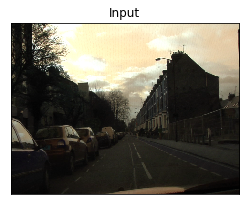

In [13]:
import scipy
from scipy.misc import imresize, imread, imshow
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
import cv2

ind = 12
testPT = xtestT[ind]

testPT = testPT.view(1,3,360,480)
test_pred = net.forward(Variable(testPT, volatile=True).cuda())
test_pred=get_predictions(test_pred)
print(test_pred.size())
testx = testPT.numpy()
testx = np.reshape(testx,(3,360,480))
testx = testx.transpose(1,2,0)
testx = imresize(testx,(360,480,3))
#imshow(testx)
scipy.misc.imsave('test_30.png', testx)
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(testx)
a.set_title('Input')
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)


In [ ]:
print(test_pred.size(),test_pred)

1st torch.Size([1, 360, 480])
2nd (1, 360, 480)
firt (360, 480, 3)
second (360, 480, 1)
third (360, 480)
fourth (360, 480)


/home/shahzad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


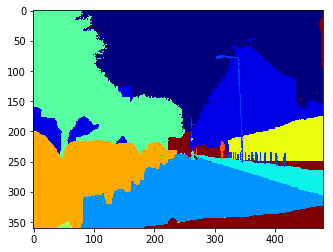

In [14]:
import scipy
from scipy.misc import imresize, imread, imshow
from PIL import Image

import cv2


tar = ytestT[ind]
print("1st",tar.shape)


tar_x = tar.numpy()

print("2nd",tar_x.shape)


#testx = testPT.numpy()
tar_x = np.reshape(tar_x,(1,360,480))
print("firt",testx.shape)
tar_x = tar_x.transpose(1,2,0)
print("second",tar_x.shape)






tar_x = cv2.resize(tar_x,(480,360))
print("third",tar_x.shape)



scipy.misc.imsave('tar_30.png', tar_x)
imgplot = plt.imshow(tar_x)
imgplot.set_cmap('jet')
print("fourth",tar_x.shape)


torch.Size([1, 360, 480])
torch.Size([1, 360, 480])
firt (1, 360, 480)
second (360, 480, 1)
third (360, 480)
fourth (360, 480)


/home/shahzad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


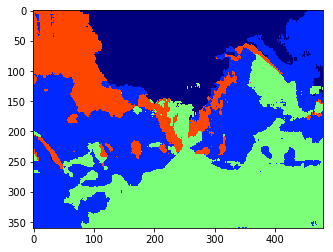

In [15]:
import scipy
from scipy.misc import imresize, imread, imshow
from PIL import Image

import cv2

print(test_pred.shape)
pred = test_pred.cpu()
print(pred.shape)
pred = pred.detach().numpy()

#testx = testPT.numpy()
pred = np.reshape(pred,(1,360,480))
print("firt",pred.shape)
pred = pred.transpose(1,2,0)
print("second",pred.shape)
pred = cv2.resize(pred,(480,360))
print("third",pred.shape)
scipy.misc.imsave('pred_30.png', pred)
imgplot = plt.imshow(pred)
imgplot.set_cmap('jet')
print("fourth",tar_x.shape)


In [ ]:
error=abs(tar_x-testx)
print(error.shape)
scipy.misc.imsave('error_200.png', error)
imgplot = plt.imshow(error)
imgplot.set_cmap('jet')


In [16]:
intersection = np.logical_and(tar_x, pred)
union = np.logical_or(tar_x, pred)
iou_score = np.sum(intersection) / np.sum(union) 

In [17]:
print(iou_score, intersection.shape, union.shape, np.sum(intersection),np.sum(union))

0.9163022378493206 (360, 480) (360, 480) 125089 136515
